In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Utils
from scipy.optimize import minimize 
import Backtest as bt   
import matplotlib.dates as mdates


In [2]:
# SET GLOBAL VALUES
mu_target = 75 / 10000 # Target
w_current = np.array([0,0.4, 0.6]) # current strategy


In [3]:
bond = pd.read_csv("Data_clean/bond_returns.csv")
stock = pd.read_csv("Data_clean/6_Portfolios_ME_Prior_12_2_returns.csv")
bond, stock =bond[["Date", "10YrReturns"]], stock[["Date", "Market Return"]]
stock["Market Return"] = stock["Market Return"] /100  


In [4]:
data = pd.merge(bond,stock, how='left', on = "Date")
RF = pd.read_csv("Data_clean/FF_cleaned.csv")
data = pd.merge(data.copy(),RF, 'left',on = "Date" )
data["RF"] = data["RF"] /100 # assumed this must hold

In [5]:
data

,Date,10YrReturns,Market Return,Mkt-RF,SMB,HML,RF
0,1990-01-31,-0.025702,-0.0724,-7.85,-1.24,0.85,0.0057
1,1990-02-28,0.001547,0.0167,1.11,0.99,0.64,0.0057
2,1990-03-31,-0.002251,0.0246,1.83,1.50,-2.92,0.0064
3,1990-04-30,-0.017928,-0.0266,-3.36,-0.46,-2.59,0.0069
4,1990-05-31,0.035839,0.0909,8.42,-2.53,-3.83,0.0068
...,...,...,...,...,...,...,...
403,2023-08-31,-0.006376,-0.0190,-2.39,-3.20,-1.08,0.0045
404,2023-09-30,-0.035790,-0.0480,-5.24,-2.49,1.45,0.0043
405,2023-10-31,-0.018635,-0.0261,-3.18,-3.88,0.19,0.0047
406,2023-11-30,0.044330,0.0930,8.83,-0.03,1.66,0.0044


In [6]:
mu = np.mean([data["RF"],data["10YrReturns"],data["Market Return"]],axis=1)
sigma = np.cov([data["RF"],data["10YrReturns"],data["Market Return"]])
mu2 = np.mean([data["10YrReturns"],data["Market Return"]],axis=1)
sigma2 = np.cov([data["10YrReturns"],data["Market Return"]])
print("Mu", mu,"Sigma", sigma)


Mu [0.00213848 0.00432316 0.00930956] Sigma [[ 3.53053036e-06  4.63693106e-06 -2.61646372e-07]
 [ 4.63693106e-06  4.51987323e-04 -6.42279174e-05]
 [-2.61646372e-07 -6.42279174e-05  1.94512573e-03]]


In [7]:
# Current portfolio return and risk:
mu_4060 = w_current @ mu 
sigma_4060 =np.sqrt(w_current @ sigma @ w_current)

print("PF-value per month in bps", mu_4060 , "PF-std" , sigma_4060 )


PF-value per month in bps 0.007315000330233509 PF-std 0.02723479088829775


In [8]:
# Now for finding the weights that give optimal port with :
w_global = np.linalg.inv(sigma) @ np.ones(shape=3) / (np.ones(shape=3) @ np.linalg.inv(sigma) @ np.ones(shape=3))
mu_gmv = mu @ w_global
print("Global minimum variance pf",w_global, "global min var return", mu_gmv)

Global minimum variance pf [ 1.00033454 -0.0022064   0.00187186] global min var return 0.002147083393965425


In [9]:
# minimum variance given target:
w_target, sigma_target = Utils.min_var(mu, sigma,mu_target) 
print("Weight:", w_target, "Minimum std of target mu",sigma_target, "Mu" )

Weight: [0.         0.36289919 0.6371008 ] Minimum std of target mu 0.028624237311923935 Mu


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


In [10]:
# But if we consider the actual return from the pf:
# w_target, sigma_target = Utils.min_var(mu, sigma,mu_4060) 
# print("Weight:", w_target, "Minimum sigma of target mu",sigma_target)
# Actually really close to mean variance efficient
#BUT: IT DOES NOT DELIVER THE CORRESPONDING RETURN!
print("Return current PF", mu_4060, "!= Return Target",mu_target)

print("Reduction in risk in Variance:", (sigma_target -  sigma_4060)*10000 )


Return current PF 0.007315000330233509 != Return Target 0.0075
Reduction in risk in Variance: 13.894464236261852


In [11]:
# Plot mean variance frontier:
mu_vec = np.array([mu_target + i*0.0001 for i in range(-80,40)])
sigma_vec = [Utils.mv_analysis(mu, sigma,i)[1] for i in mu_vec]

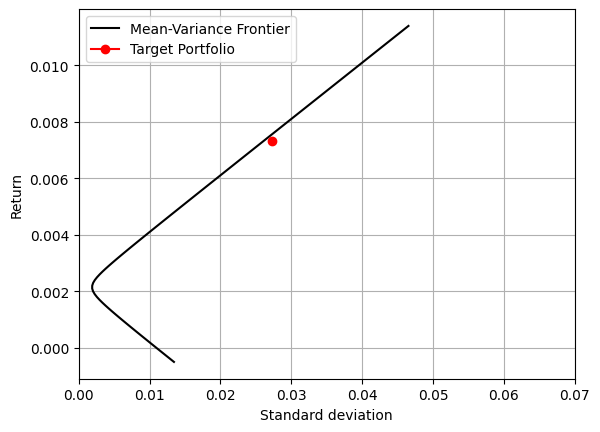

In [12]:
plt.plot(sigma_vec, mu_vec, color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_4060,mu_4060,marker='o', color = "red", label = "Target Portfolio")
plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.xlim(left = 0.0,right= 0.07)

plt.grid()
plt.show()

In [13]:
# We can then use functionality...
mu0 = np.mean(data["RF"])
mu_e = np.mean([data["10YrReturns"] - data["RF"],data["Market Return"]-data["RF"]],axis=1)
sigma_e = np.cov([data["10YrReturns"] - data["RF"],data["Market Return"] - data["RF"]])
mu_target_e = mu_target - mu0
mu_e, sigma_e

(array([0.00218468, 0.00717108]),
 array([[ 4.46243992e-04, -6.50726717e-05],
        [-6.50726717e-05,  1.94917955e-03]]))

In [14]:
w_target, sigma_target_e = Utils.min_var_rf(mu, sigma,mu_target) 
print(w_target, sigma_target)
# Got riskier.

[-0.258859    0.73517163  0.52368737] 0.028624237311923935


In [15]:
# Surprisingly risk is increased?
# Return:
mu_cml = np.array(w_target) @ np.array(mu) 
print(mu_cml)

0.007500000000424841


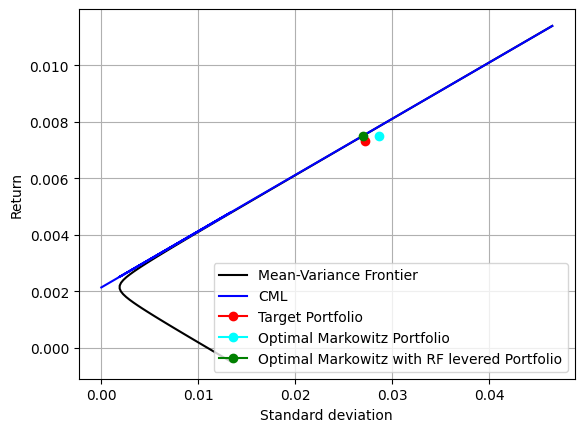

In [16]:
# Plot mean variance frontier:
sigma_vec_cml = [0]+ sigma_vec
cml = [ mu0 + np.sqrt(mu_e @ np.linalg.inv(sigma_e) @ mu_e) * i for i in sigma_vec_cml]
plt.plot(sigma_vec, mu_vec, color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec_cml, cml, color = "blue",label = "CML")
plt.plot(sigma_4060,mu_4060,marker='o', color = "red", label = "Target Portfolio")
plt.plot(sigma_target,mu_target,marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_target_e,mu_cml,marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")
plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

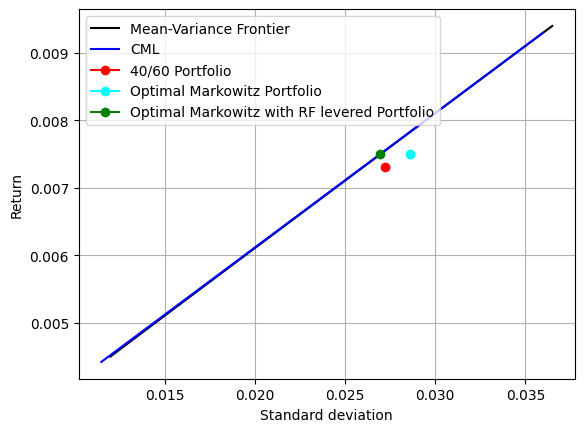

In [17]:
# close up:
# Plot mean variance frontier:
plt.plot(sigma_vec[50:100], mu_vec[50:100], color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec_cml[50:100], cml[50:100], color = "blue",label = "CML")
plt.plot(sigma_4060,mu_4060,marker='o', color = "red", label = "40/60 Portfolio")
plt.plot(sigma_target,mu_target,marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_target_e,mu_cml,marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")
plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

Risk Parity

In [18]:
# Try with scipys' minimize - allow no shorting at first

def risk_parity_fun(w,sigma,lev):
    if lev == True:
        w = w[1:]
    std = np.sqrt(w @ sigma @ w)
    N  = len(w)
    w_rp = std**2 / ((sigma @ w) * N)
    fun = np.sum((w - w_rp)**2)
    
    return fun


In [19]:
constraints_rp = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]  # Target return

N = int(len(sigma2[1,:]))
w0 = np.ones(N) / N
res = minimize(fun = risk_parity_fun, x0 = w0, method = 'trust-constr', 
                    args =(sigma[1:,1:],False),
                    bounds = ((0,1),(0,1)),
                        constraints=constraints_rp)
w_rp = res.x
sigma_rp = np.sqrt(w_rp @ sigma2 @w_rp)
w_rp = np.append(0,w_rp)
print("w",w_rp, "Sum of Squares", res.fun )

w [0.         0.67474248 0.32525752] Sum of Squares 4.940571201079971e-16


In [20]:
# check of function: 
check = w_rp *  ( sigma @ w_rp) /np.sqrt(w_rp @ sigma @ w_rp)
check2 = np.sqrt(w_rp @ sigma @ w_rp) / len(w_rp)
pf_risk = np.sqrt(w_rp @ sigma @ w_rp)
print("Actual risk weight", check, "Target", check2, "Portfolio risk", pf_risk)
sigma_rp = np.sqrt(w_rp @ sigma @ w_rp)
mu_rp = mu @ w_rp

Actual risk weight [0.         0.00978989 0.00978989] Target 0.0065265924304003286 Portfolio risk 0.019579777291200987


In [21]:
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights >= 1
               {'type': 'eq', 'fun': lambda w: np.dot(w, mu) - mu_target}  
]
N = int(len(sigma[0,:]))
w0 = np.ones(N) / N
res = minimize(fun = risk_parity_fun, x0 = w0, method = 'trust-constr', 
                    args =(sigma2,True),
                    bounds = ((-0.5,0),(0,1.5),(0,1.5)),
                        constraints=constraints)
# Note we impose to actually borrow. 
w_rp_lev = res.x
sigma_rp_lev = np.sqrt(w_rp_lev @ sigma @ w_rp_lev)

print("w",w_rp_lev, "Sum of Squares", res.fun )
mu_rp_lev = mu @ w_rp_lev
check = w_rp_lev[1:] *  ( sigma2 @ w_rp_lev[1:]) /sigma_rp_lev
check2 = sigma_rp_lev / len(w_rp_lev)
pf_risk = check + check
print("Actual risk weight", check, "Target", check2, "Portfolio risk", pf_risk)



w [-0.40849609  0.95036898  0.45812711] Sum of Squares 1.3445959910999145e-10
Actual risk weight [0.01381538 0.01381568] Target 0.009175073356106825 Portfolio risk [0.02763076 0.02763136]


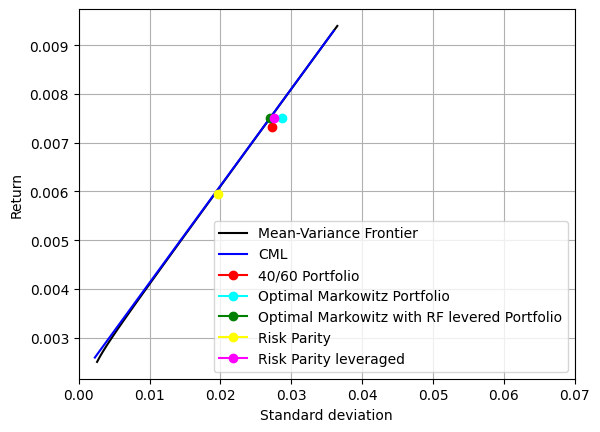

In [22]:
# Plot mean variance frontier:
plt.plot(sigma_vec[30:100], mu_vec[30:100], color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec_cml[30:100], cml[30:100], color = "blue",label = "CML")
plt.plot(sigma_4060,mu_4060,marker='o', color = "red", label = "40/60 Portfolio")
plt.plot(sigma_target,mu_target,marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_target_e,mu_cml,marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")
plt.plot(sigma_rp,mu_rp,marker='o', color = "yellow", label = "Risk Parity")
plt.plot(sigma_rp_lev,mu_rp_lev,marker='o', color = "magenta", label = "Risk Parity leveraged")
plt.xlim(left = 0.0,right= 0.07)
plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

In [23]:
# Test weights:
test = Utils.get_weights(mu,sigma, mu_target)
print(test)

[array([0. , 0.4, 0.6]), array([0.        , 0.36289919, 0.6371008 ]), array([-0.258859  ,  0.73517163,  0.52368737]), array([0.        , 0.67474248, 0.32525752]), array([-0.40849609,  0.95036898,  0.45812711])]


In [24]:
sigma_test, mu_test = [np.sqrt(w @ sigma @ w) for w in test],  [w @ mu for w in test]



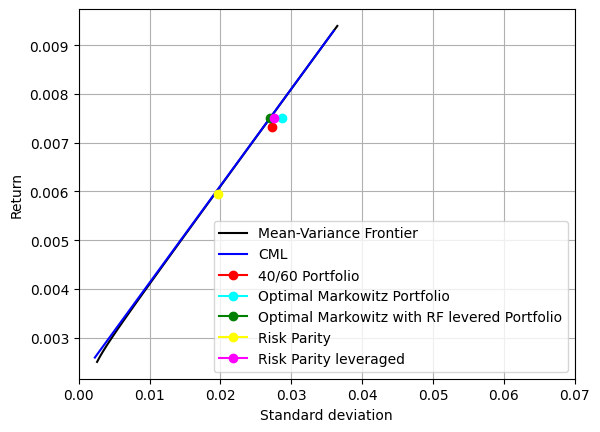

In [25]:
plt.plot(sigma_vec[30:100], mu_vec[30:100], color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec_cml[30:100], cml[30:100], color = "blue",label = "CML")
plt.plot(sigma_test[0],mu_test[0],marker='o', color = "red", label = "40/60 Portfolio")
plt.plot(sigma_test[1],mu_test[1],marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_test[2],mu_test[2],marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")
plt.plot(sigma_test[3],mu_test[3],marker='o', color = "yellow", label = "Risk Parity")
plt.plot(sigma_test[4],mu_test[4],marker='o', color = "magenta", label = "Risk Parity leveraged")
plt.xlim(left = 0.0,right= 0.07)

plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

In [26]:
initial_fits = 3

test1, weights1 = bt.backtest_k(ind=data, mu_target=mu_target,m=initial_fits,l=1,K=1) 



c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.up

C:\Users\andre\AppData\Local\Temp\ipykernel_24396\2736931595.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


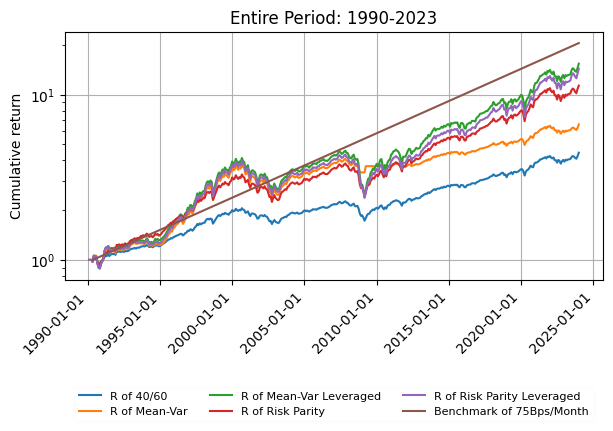

In [27]:
time = pd.date_range(test1["Date"][0],test1["Date"][len(test1["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test1["R_40/60"], label="R of 40/60")
ax.plot(time,test1["R_MV"], label="R of Mean-Var")
ax.plot(time,test1["R_MVL"], label="R of Mean-Var Leveraged")
ax.plot(time,test1["R_RP"], label="R of Risk Parity")
ax.plot(time,test1["R_RPL"], label="R of Risk Parity Leveraged")
ax.plot(time[initial_fits:], [(mu_target+1)**t for t in range(0,len(time)-initial_fits)],
         label = "Benchmark of 75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.title("Entire Period: 1990-2023")
plt.show()

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better res

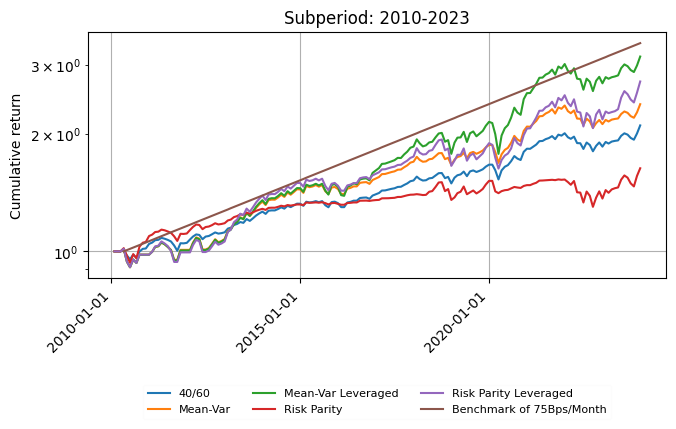

In [28]:
data1 = data.copy()
# Now perform the comparison
data1 = data1[pd.Timestamp('2010-01-31') <=pd.to_datetime(data1["Date"])]
data1 = data1.reset_index().drop(columns = "index")

test2, weights2 = bt.backtest_k(ind=data1, mu_target=mu_target,m=initial_fits,l=1,K=1) # 36 trailing month windowfig,
time = pd.date_range(test2["Date"][0],test2["Date"][len(test2["Date"]) -1 ], freq = 'ME')

firg, ax = plt.subplots(layout='constrained')
ax.plot(time,test2["R_40/60"], label="40/60")
ax.plot(time,test2["R_MV"], label="Mean-Var")
ax.plot(time,test2["R_MVL"], label="Mean-Var Leveraged")
ax.plot(time,test2["R_RP"], label="Risk Parity")
ax.plot(time,test2["R_RPL"], label="Risk Parity Leveraged")
ax.plot(time[initial_fits:], [(mu_target+1)**t for t in range(0,len(time)-initial_fits)],
         label = "Benchmark of 75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.title("Subperiod: 2010-2023")
plt.show()


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.up

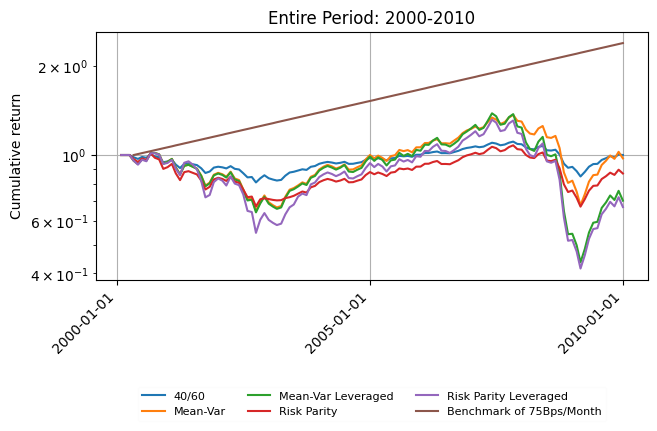

In [29]:
data1 = data.copy()
# Now perform the comparison
data1 = data1[(pd.Timestamp('2010-01-31') > pd.to_datetime(data1["Date"])) & (pd.Timestamp('2000-01-31') <= pd.to_datetime(data1["Date"]))]
data1 = data1.reset_index().drop(columns = "index")

test3, weights3 = bt.backtest_k(ind=data1, mu_target=mu_target,m=initial_fits,l=1,K=1) # 36 trailing month window
time = pd.date_range(test3["Date"][0],test3["Date"][len(test3["Date"]) -1 ], freq = 'ME')

fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test3["R_40/60"], label="40/60")
ax.plot(time,test3["R_MV"], label="Mean-Var")
ax.plot(time,test3["R_MVL"], label="Mean-Var Leveraged")
ax.plot(time,test3["R_RP"], label="Risk Parity")
ax.plot(time,test3["R_RPL"], label="Risk Parity Leveraged")
ax.plot(time[initial_fits:], [(mu_target+1)**t for t in range(0,len(time)-initial_fits)],
         label = "Benchmark of 75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.title("Entire Period: 2000-2010")
plt.show()


In [30]:
# Check some of the weights on average. 
for j in range(0,5):
    for i in range(0,len(weights1)):
        if i == 0:
            avg = 0
        avg += weights1[i][j]
        if i == len(weights1)-1:
            print("Average Portfolio holdins", avg/len(weights1))


Average Portfolio holdins [0.  0.4 0.6]
Average Portfolio holdins [0.         0.56939763 0.43059787]
Average Portfolio holdins [-0.12558883  0.82356045  0.30202659]
Average Portfolio holdins [0.         0.67789116 0.32210884]
Average Portfolio holdins [-0.13543207  0.82970877  0.3057215 ]


In [31]:
# Check some of the weights on average. 
for j in range(0,5):
    for i in range(0,len(weights2)):
        if i == 0:
            avg = 0
        avg += weights2[i][j]
        if i == len(weights2)-1:
            print("Average Portfolio holdins", avg/len(weights2))

Average Portfolio holdins [0.  0.4 0.6]
Average Portfolio holdins [0.         0.54989893 0.45009888]
Average Portfolio holdins [-0.11181218  0.70510227  0.40670882]
Average Portfolio holdins [0.        0.3598755 0.6401245]
Average Portfolio holdins [-0.13988458  0.73512864  0.40475485]


In [32]:
# Check some of the weights on average. 
for j in range(0,5):
    for i in range(0,len(weights3)):
        if i == 0:
            avg = 0
        avg += weights3[i][j]
        if i == len(weights3)-1:
            print("Average Portfolio holdins", avg/len(weights3))

Average Portfolio holdins [0.  0.4 0.6]
Average Portfolio holdins [0.         0.94178372 0.05821623]
Average Portfolio holdins [-0.24061219  1.16396797  0.07664335]
Average Portfolio holdins [0.         0.66424499 0.33575501]
Average Portfolio holdins [-0.30309936  1.21401905  0.08907944]


In [42]:
# It seems that the optimizers work really badly at first
# Perhaps if 1 year is used for estimation, things would work out better?

[weights1[19][i].round(4) for i in range(0,5)]

[array([0. , 0.4, 0.6]),
 array([ 0.,  1., -0.]),
 array([ 0.,  1., -0.]),
 array([0.    , 0.7374, 0.2626]),
 array([ 0.,  1., -0.])]

In [36]:
len(weights1)

404

np.float64(3.9686824665132128)